
# Linear Regression — Advertising Dataset

This notebook operationalizes the concepts from the lecture slides. It covers Simple and Multiple Linear Regression, estimation via least squares, inference (standard errors, confidence intervals, hypothesis tests), goodness-of-fit metrics (RSE, $R^2$, F-statistic), correlation analysis, and model selection (forward and backward stepwise).


In [47]:
# Setup
import sys
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure statsmodels is available
try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
except ImportError:
    %pip install statsmodels
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

# ----- User parameter: CSV file path -----
# Update CSV_FILE to the filename of your attached dataset if needed.
# Common names: "Advertising.csv" or "advertising.csv"
CSV_FILE = "Advertising.csv"

# Robust loader that standardizes expected columns
df_raw = pd.read_csv(CSV_FILE)

# Standardize column names
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

# Attempt to map common variants to expected names
col_map = {}
expected = {"tv": None, "radio": None, "newspaper": None, "sales": None}
for c in df.columns:
    cl = c.lower()
    if "tv" == cl or "tv" in cl:
        expected["tv"] = c
    elif "radio" == cl:
        expected["radio"] = c
    elif "news" in cl or "newspaper" in cl:
        expected["newspaper"] = c
    elif "sales" == cl or "sale" == cl:
        expected["sales"] = c

# Fallbacks: if exact matches fail, try heuristic matching
for k in expected:
    if expected[k] is None:
        # choose closest name by simple rules
        if k == "tv":
            candidates = [c for c in df.columns if "tv" in c]
            expected[k] = candidates[0] if candidates else None
        if k == "newspaper":
            candidates = [c for c in df.columns if "news" in c or "paper" in c]
            expected[k] = candidates[0] if candidates else None
        if k == "sales":
            candidates = [c for c in df.columns if "sale" in c]
            expected[k] = candidates[0] if candidates else None

# Rename to canonical names if found
renames = {}
for canonical, actual in expected.items():
    if actual is None:
        raise ValueError(f"Could not find required column for '{canonical}'. "
                         f"Columns present: {list(df.columns)}")
    if canonical != actual:
        renames[actual] = canonical

df = df.rename(columns=renames)

# Basic checks and preview
# display(df.head())
# print("Columns:", list(df.columns))
# print("Shape:", df.shape)
# assert set(["tv","radio","newspaper","sales"]).issubset(df.columns), "Required columns not found."

# If the dataset includes an index-like column, drop it
for idx_like in ["unnamed: 0", "index"]:
    if idx_like in df.columns:
        df = df.drop(columns=[idx_like])

df = df[["tv","radio","newspaper","sales"]].copy()

display(df.head())

df.describe()


,tv,radio,newspaper,sales
0,230.1000,37.8000,69.2000,22.1000
1,44.5000,39.3000,45.1000,10.4000
2,17.2000,45.9000,69.3000,9.3000
3,151.5000,41.3000,58.5000,18.5000
4,180.8000,10.8000,58.4000,12.9000


,tv,radio,newspaper,sales
count,200.0000,200.0000,200.0000,200.0000
mean,147.0425,23.2640,30.5540,14.0225
std,85.8542,14.8468,21.7786,5.2175
min,0.7000,0.0000,0.3000,1.6000
25%,74.3750,9.9750,12.7500,10.3750
50%,149.7500,22.9000,25.7500,12.9000
75%,218.8250,36.5250,45.1000,17.4000
max,296.4000,49.6000,114.0000,27.0000



## Linear Regression

Linear regression assumes that the dependence of $Y$ on $X_1, X_2, \ldots, X_p$ is linear. While true data-generating processes are rarely perfectly linear, the linear model is widely useful—conceptually and practically.



# Simple Linear Regression

We begin with a single predictor $X$ (TV) and response $Y$ (sales):
$$
Y = \beta_0 + \beta_1 X + \epsilon.
$$

Given estimates $(\hat{\beta_0}, \hat{\beta_1})$, predictions are $\hat{y} = \hat{\beta_0} + \hat{\beta_1} x$.


In [48]:
# Closed-form least squares for TV -> sales
x = df["tv"].to_numpy()
y = df["sales"].to_numpy()
n = len(y)

xbar = x.mean()
ybar = y.mean()

Sxx = np.sum((x - xbar)**2)
Sxy = np.sum((x - xbar)*(y - ybar))

beta1_hat_closed = Sxy / Sxx
beta0_hat_closed = ybar - beta1_hat_closed * xbar

yhat_closed = beta0_hat_closed + beta1_hat_closed * x
resid_closed = y - yhat_closed
RSS_closed = np.sum(resid_closed**2)
sigma2_hat = RSS_closed / (n - 2)

# Standard errors
SE_beta1 = math.sqrt(sigma2_hat / Sxx)
SE_beta0 = math.sqrt(sigma2_hat * (1/n + (xbar**2)/Sxx))

# 95% CI for beta1 using ~2*SE shorthand (approximation) and exact t-quantile
from scipy import stats
t_crit = stats.t.ppf(0.975, df=n-2)  # two-sided 95%

ci_beta1_approx = (beta1_hat_closed - 2*SE_beta1, beta1_hat_closed + 2*SE_beta1)
ci_beta1_exact = (beta1_hat_closed - t_crit*SE_beta1, beta1_hat_closed + t_crit*SE_beta1)

# RSE and R^2
RSE = math.sqrt(RSS_closed / (n - 2))
TSS = np.sum((y - ybar)**2)
R2 = 1 - RSS_closed / TSS

# Correlation r and r^2 check
r = np.corrcoef(x, y)[0,1]
r2_check = r**2

# Format confidence intervals as strings
ci_beta1_approx_str = f"[{ci_beta1_approx[0]:.4f}, {ci_beta1_approx[1]:.4f}]"
ci_beta1_exact_str  = f"[{ci_beta1_exact[0]:.4f}, {ci_beta1_exact[1]:.4f}]"

summary_simple_manual = pd.DataFrame({
    "Quantity": [
        "beta0_hat (intercept)",
        "beta1_hat (slope for TV)",
        "SE(beta0)",
        "SE(beta1)",
        "95% CI beta1 (approx 2*SE)",
        "95% CI beta1 (exact t)",
        "RSE",
        "R^2",
        "Correlation r",
        "r^2"
    ],
    "Value": [
        f"{beta0_hat_closed:.4f}",
        f"{beta1_hat_closed:.4f}",
        f"{SE_beta0:.4f}",
        f"{SE_beta1:.4f}",
        ci_beta1_approx_str,
        ci_beta1_exact_str,
        f"{RSE:.4f}",
        f"{R2:.4f}",
        f"{r:.4f}",
        f"{r2_check:.4f}"
    ]
})
display(summary_simple_manual.style.format(precision=4))

# OLS via statsmodels for comparison
model_tv = smf.ols("sales ~ tv", data=df).fit()
print(model_tv.summary())


,Quantity,Value
0,beta0_hat (intercept),7.0326
1,beta1_hat (slope for TV),0.0475
2,SE(beta0),0.4578
3,SE(beta1),0.0027
4,95% CI beta1 (approx 2*SE),"[0.0422, 0.0529]"
5,95% CI beta1 (exact t),"[0.0422, 0.0528]"
6,RSE,3.2587
7,R^2,0.6119
8,Correlation r,0.7822
9,r^2,0.6119


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.47e-42
Time:                        16:16:09   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0


### Visualization: TV vs. Sales with Fitted Line


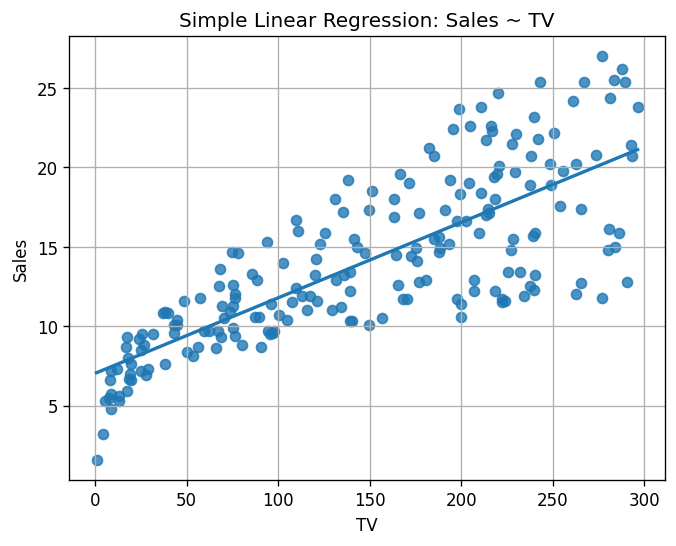

In [49]:

plt.figure()
plt.scatter(df["tv"], df["sales"], alpha=0.8)
x_grid = np.linspace(df["tv"].min(), df["tv"].max(), 200)
y_fit = beta0_hat_closed + beta1_hat_closed * x_grid
plt.plot(x_grid, y_fit, linewidth=2)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title("Simple Linear Regression: Sales ~ TV")
plt.show()



## Hypothesis Testing for the Slope

We test $H_0: \beta_1 = 0$ vs. $H_A: \beta_1 \neq 0$ using
$$
t = \frac{\hat{\beta_1} - 0}{SE(\hat{\beta_1})} \sim t_{n-2} \text{ under } H_0.
$$


In [50]:
t_stat = beta1_hat_closed / SE_beta1
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))

pd.DataFrame({
    "Coefficient": ["Intercept", "TV"],
    "Estimate": [beta0_hat_closed, beta1_hat_closed],
    "Std. Error": [SE_beta0, SE_beta1],
    "t-statistic": [beta0_hat_closed/SE_beta0, t_stat],
    "p-value": [2*(1-stats.t.cdf(abs(beta0_hat_closed/SE_beta0), df=n-2)), p_value]
}).style.format(precision=4)


,Coefficient,Estimate,Std. Error,t-statistic,p-value
0,Intercept,7.0326,0.4578,15.3603,0.0000
1,TV,0.0475,0.0027,17.6676,0.0000



## Assessing Overall Accuracy

Residual Standard Error (RSE):

$$
\text{RSE} = \sqrt{\frac{1}{n-2}\sum_{i=1}^n (y_i - \hat{y_i})^2}
$$

Fraction of variance explained:
$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}},\quad \text{where}\; \text{TSS} = \sum_{i=1}^n (y_i - \bar{y})^2.
$$

In simple linear regression, $R^2 = r^2$, where $r$
 is the correlation between X and Y:


In [51]:
# F-statistic for the simple regression (1 predictor)
p = 1
F_stat = ((TSS - RSS_closed)/p) / (RSS_closed/(n - p - 1))
F_p_value = 1 - stats.f.cdf(F_stat, dfn=p, dfd=n - p - 1)

metrics_simple = pd.DataFrame({
    "Quantity": ["Residual Standard Error", "R^2", "F-statistic", "F p-value"],
    "Value": [RSE, R2, F_stat, F_p_value]
})
display(metrics_simple.style.format(precision=4))


,Quantity,Value
0,Residual Standard Error,3.2587
1,R^2,0.6119
2,F-statistic,312.1450
3,F p-value,0.0000



# Multiple Linear Regression

We now model
$$
\text{sales} = \beta_0 + \beta_1\,\text{tv} + \beta_2\,\text{radio} + \beta_3\,\text{newspaper} + \epsilon.
$$

Interpretation of $\\beta_j$: the average change in $Y$ for a one-unit increase in $X_j$, holding other predictors fixed.


In [52]:

model_full = smf.ols("sales ~ tv + radio + newspaper", data=df).fit()
print(model_full.summary())

# Coefficients table in the slide format
coefs = model_full.params
ses = model_full.bse
tvals = model_full.tvalues
pvals = model_full.pvalues

tab_full = pd.DataFrame({
    "Predictor": ["Intercept", "tv", "radio", "newspaper"],
    "Coefficient": [coefs["Intercept"], coefs["tv"], coefs["radio"], coefs["newspaper"]],
    "Std. Error": [ses["Intercept"], ses["tv"], ses["radio"], ses["newspaper"]],
    "t-statistic": [tvals["Intercept"], tvals["tv"], tvals["radio"], tvals["newspaper"]],
    "p-value": [pvals["Intercept"], pvals["tv"], pvals["radio"], pvals["newspaper"]]
})
display(tab_full.style.format(precision=4))

# Correlation matrix (Pearson)
corr = df[["tv","radio","newspaper","sales"]].corr()
display(corr.style.format(precision=4))

# Overall metrics analogous to the slide
RSE_full = math.sqrt(model_full.ssr / model_full.df_resid)  # sqrt(RSS / (n - p - 1))
R2_full = model_full.rsquared
F_full = model_full.fvalue
F_p_full = model_full.f_pvalue

metrics_full = pd.DataFrame({
    "Quantity": ["Residual Standard Error", "R^2", "F-statistic", "F p-value"],
    "Value": [RSE_full, R2_full, F_full, F_p_full]
})
display(metrics_full.style.format(precision=4))


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.58e-96
Time:                        16:16:09   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

,Predictor,Coefficient,Std. Error,t-statistic,p-value
0,Intercept,2.9389,0.3119,9.4223,0.0000
1,tv,0.0458,0.0014,32.8086,0.0000
2,radio,0.1885,0.0086,21.8935,0.0000
3,newspaper,-0.0010,0.0059,-0.1767,0.8599


,tv,radio,newspaper,sales
tv,1.0000,0.0548,0.0566,0.7822
radio,0.0548,1.0000,0.3541,0.5762
newspaper,0.0566,0.3541,1.0000,0.2283
sales,0.7822,0.5762,0.2283,1.0000


,Quantity,Value
0,Residual Standard Error,1.6855
1,R^2,0.8972
2,F-statistic,570.2707
3,F p-value,0.0000



## Global Utility of Predictors

Use the model F-statistic:
$$
F = \frac{(\text{TSS} - \text{RSS})/p}{\text{RSS}/(n - p - 1)} \sim F_{p, n-p-1}.
$$

A large $F$ with small $p$-value indicates at least one $\beta_j \neq 0$.


In [53]:

# Already computed in metrics_full
# metrics_full
metrics_full.style.format(precision=4, formatter={ "Value": "{:.4f}".format })


,Quantity,Value
0,Residual Standard Error,1.6855
1,R^2,0.8972
2,F-statistic,570.2707
3,F p-value,0.0000



# Qualitative Predictors — Credit Card Data

This notebook reproduces the slide content using the `Credit.csv` dataset.
It demonstrates:
- Handling qualitative predictors via dummy/factor encoding.
- A binary-predictor example (e.g., `Gender` if present; otherwise a binary field like `Student`).
- A multi-level categorical example (`Ethnicity` if present; otherwise a multi-level field like `Region`).


In [54]:
# Imports
import os
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Resolve data path
candidate_paths = ["Credit.csv", "/mnt/data/Credit.csv"]
csv_path = next((p for p in candidate_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("Credit.csv not found. Place it next to this notebook or at /mnt/data/Credit.csv.")

# Load data
df = pd.read_csv(csv_path)

print("Data shape:", df.shape)
df.head()


Data shape: (400, 11)


,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.8910,3606,283,2,34,11,No,No,Yes,South,333
1,106.0250,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.5930,7075,514,4,71,11,No,No,No,West,580
3,148.9240,9504,681,3,36,11,Yes,No,No,West,964
4,55.8820,4897,357,2,68,16,No,No,Yes,South,331


In [55]:
# Identify candidate qualitative predictors
obj_cols = [c for c in df.columns if df[c].dtype == 'object']
levels = {c: sorted(df[c].dropna().unique().tolist()) for c in obj_cols}

binary_candidates = [c for c in obj_cols if len(levels[c]) == 2]
multilevel_candidates = [c for c in obj_cols if len(levels[c]) > 2]

print("Object (categorical) columns:", obj_cols)
print("Binary candidates:", {c: levels[c] for c in binary_candidates})
print("Multi-level candidates:", {c: levels[c] for c in multilevel_candidates})


Object (categorical) columns: ['Own', 'Student', 'Married', 'Region']
Binary candidates: {'Own': ['No', 'Yes'], 'Student': ['No', 'Yes'], 'Married': ['No', 'Yes']}
Multi-level candidates: {'Region': ['East', 'South', 'West']}



## Qualitative Predictors

- Some predictors are **qualitative**, taking discrete values (e.g., gender, ethnicity).
- Categorical predictors can be represented using **factor** (dummy) variables.
- Examples of qualitative variables (depending on this dataset's columns): `Gender`, `Student`, `Married`, `Ethnicity`, `Region`, `Own`.


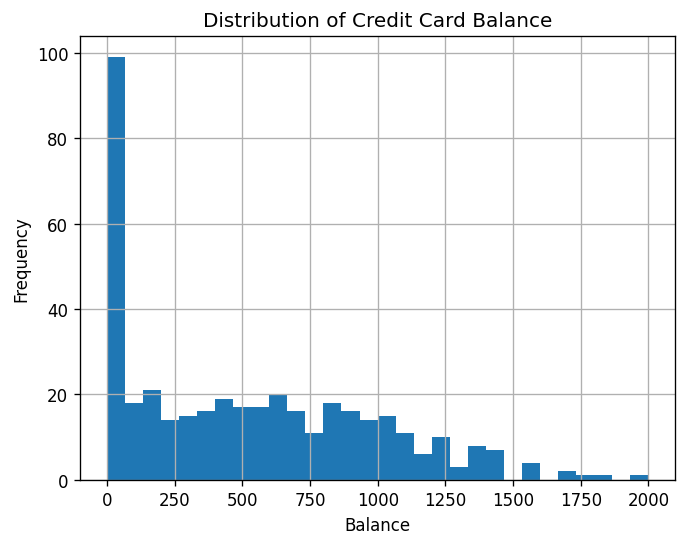

In [56]:
# Simple figure to mirror the slide's "Credit Card Data" visual with matplotlib (no styling).
plt.figure()
df["Balance"].plot(kind="hist", bins=30)
plt.title("Distribution of Credit Card Balance")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()



## Credit Card Data — Binary Qualitative Predictor Example

We investigate differences in credit card balance between two groups defined by a binary qualitative predictor.



In [57]:
# Choose binary predictor: prefer 'Gender' if available; else fall back to 'Student', 'Married', or the first binary candidate.
# preferred_order = ["Student", "Married", "Own"]
preferred_order = ["Own"]
binary_var = next((c for c in preferred_order if c in binary_candidates), None)
if binary_var is None and len(binary_candidates) > 0:
    binary_var = binary_candidates[0]

if binary_var is None:
    raise ValueError("No binary qualitative predictor found to run the binary example.")

print(f"Using binary qualitative predictor: {binary_var} with levels {levels[binary_var]}")

# Ensure two clean levels
lvl0, lvl1 = levels[binary_var][0], levels[binary_var][1]

# Fit: Balance ~ C(binary_var)
formula_bin = f"Balance ~ C({binary_var})"
model_bin = smf.ols(formula_bin, data=df).fit()

# Build a clean summary table like the slides
def tidy_table(result):
    tab = pd.DataFrame({
        "Coefficient": result.params,
        "Std. Error": result.bse,
        "t-statistic": result.tvalues,
        "p-value": result.pvalues
    })
    # Round to 2 decimals for a slide-friendly look; format very small p-values
    tab = tab.round({"Coefficient": 2, "Std. Error": 2, "t-statistic": 3, "p-value": 4})
    tab["p-value"] = tab["p-value"].apply(lambda p: "< 0.0001" if p < 1e-4 else f"{p:0.4f}")
    # Rename intercept and factor row for readability
    rename_map = { "Intercept": "Intercept" }
    # statsmodels names the dummy as C(var)[T.<level1>]
    factor_term = f"C({binary_var})[T.{lvl1}]"
    if factor_term in tab.index:
        rename_map[factor_term] = f"{binary_var} = {lvl1} (vs {lvl0})"
    tab = tab.rename(index=rename_map)
    return tab

results_bin = tidy_table(model_bin)
results_bin


Using binary qualitative predictor: Own with levels ['No', 'Yes']


,Coefficient,Std. Error,t-statistic,p-value
Intercept,509.8000,33.1300,15.3890,< 0.0001
Own = Yes (vs No),19.7300,46.0500,0.4290,0.6685


In [58]:
# Optional check: manual 0/1 coding mirroring the slide's xi definition
xi = (df[binary_var] == levels[binary_var][1]).astype(int).to_numpy()
yi = df["Balance"].to_numpy()
n = yi.size

# Closed-form OLS for y = b0 + b1*xi
xbar = xi.mean()
ybar = yi.mean()
Sxx = np.sum((xi - xbar)**2)
Sxy = np.sum((xi - xbar) * (yi - ybar))
b1 = Sxy / Sxx
b0 = ybar - b1 * xbar

# Residual variance and standard errors
resid = yi - (b0 + b1*xi)
RSS = np.sum(resid**2)
sigma2_hat = RSS / (n - 2)
SE_b1 = math.sqrt(sigma2_hat / Sxx)
SE_b0 = math.sqrt(sigma2_hat * (1/n + (xbar**2)/Sxx))

print("Closed-form estimates (0/1 coding):")
print(f"beta0_hat = {b0:.2f}, beta1_hat = {b1:.2f}")
print(f"SE_beta0 = {SE_b0:.2f}, SE_beta1 = {SE_b1:.2f}")


Closed-form estimates (0/1 coding):
beta0_hat = 509.80, beta1_hat = 19.73
SE_beta0 = 33.13, SE_beta1 = 46.05



## Qualitative Predictors with More Than Two Levels

With more than two levels, we create additional dummy variables. We fit:

$$
\text{Balance} \sim \text{C(category, Treatment(reference=baseline))}
$$


In [59]:
# Choose multi-level predictor: prefer 'Ethnicity' if available; else 'Region'; else any multi-level candidate.
preferred_multi = ["Region"]
multi_var = next((c for c in preferred_multi if c in multilevel_candidates), None)
if multi_var is None and len(multilevel_candidates) > 0:
    multi_var = multilevel_candidates[0]

if multi_var is None:
    raise ValueError("No multi-level qualitative predictor found to run the multi-level example.")

print(f"Using multi-level qualitative predictor: {multi_var} with levels {levels[multi_var]}")

# Pick a baseline (if the slide baseline exists, use it; else use the first level alphabetically)
desired_baselines = ["African American", "AA", "South"]  # examples; will fall back to first available
baseline = next((b for b in desired_baselines if b in levels[multi_var]), levels[multi_var][0])
print(f"Baseline category: {baseline}")

# Fit: Balance ~ C(multi_var, Treatment(reference=baseline))
formula_multi = f"Balance ~ C({multi_var}, Treatment(reference='{baseline}'))"
model_multi = smf.ols(formula_multi, data=df).fit()

# Tabulate results similar to slides
tab = pd.DataFrame({
    "Coefficient": model_multi.params,
    "Std. Error": model_multi.bse,
    "t-statistic": model_multi.tvalues,
    "p-value": model_multi.pvalues
})
tab = tab.round({"Coefficient": 2, "Std. Error": 2, "t-statistic": 3, "p-value": 4})
tab["p-value"] = tab["p-value"].apply(lambda p: "< 0.0001" if p < 1e-4 else f"{p:0.4f}")

# Improve row labels: Intercept and each level vs baseline
rename_map = {"Intercept": "Intercept"}
for lvl in levels[multi_var]:
    if lvl == baseline:
        continue
    sm_name = f"C({multi_var}, Treatment(reference='{baseline}'))[T.{lvl}]"
    if sm_name in tab.index:
        rename_map[sm_name] = f"{multi_var} = {lvl} (vs {baseline})"
tab = tab.rename(index=rename_map)

tab


Using multi-level qualitative predictor: Region with levels ['East', 'South', 'West']
Baseline category: South


,Coefficient,Std. Error,t-statistic,p-value
Intercept,518.5000,32.6700,15.8710,< 0.0001
Region = East (vs South),12.5000,56.6800,0.2210,0.8255
Region = West (vs South),-6.1800,56.1200,-0.1100,0.9123


In [60]:

# Baseline invariance check: RSS remains the same regardless of baseline choice.
if len(levels[multi_var]) >= 3:
    # Choose an alternative baseline if possible
    alt_candidates = [lvl for lvl in levels[multi_var] if lvl != baseline]
    alt_baseline = alt_candidates[0]
    formula_alt = f"Balance ~ C({multi_var}, Treatment(reference='{alt_baseline}'))"
    model_alt = smf.ols(formula_alt, data=df).fit()

    RSS1 = ((model_multi.resid)**2).sum()
    RSS2 = ((model_alt.resid)**2).sum()
    print(f"RSS with baseline = '{baseline}': {RSS1:,.6f}")
    print(f"RSS with baseline = '{alt_baseline}': {RSS2:,.6f}")
    print("These should be equal up to numerical rounding.")
else:
    print("Not enough levels to demonstrate baseline invariance of RSS.")


RSS with baseline = 'South': 84,321,457.709528
RSS with baseline = 'East': 84,321,457.709528
These should be equal up to numerical rounding.


<Figure size 768x576 with 0 Axes>

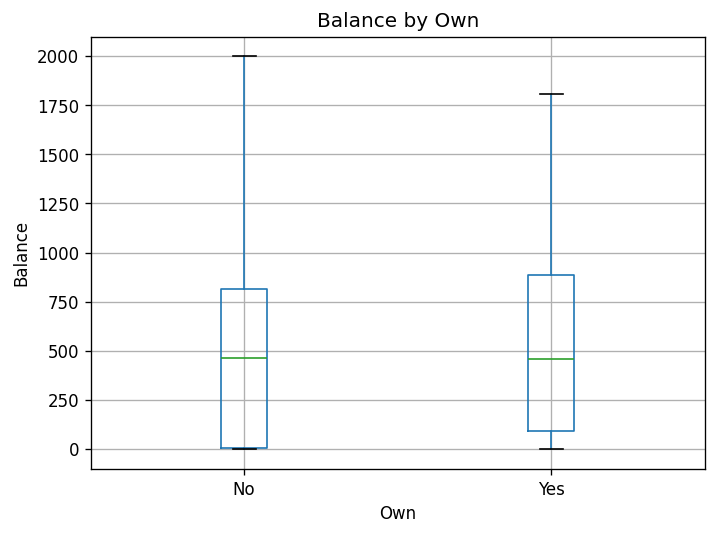

<Figure size 768x576 with 0 Axes>

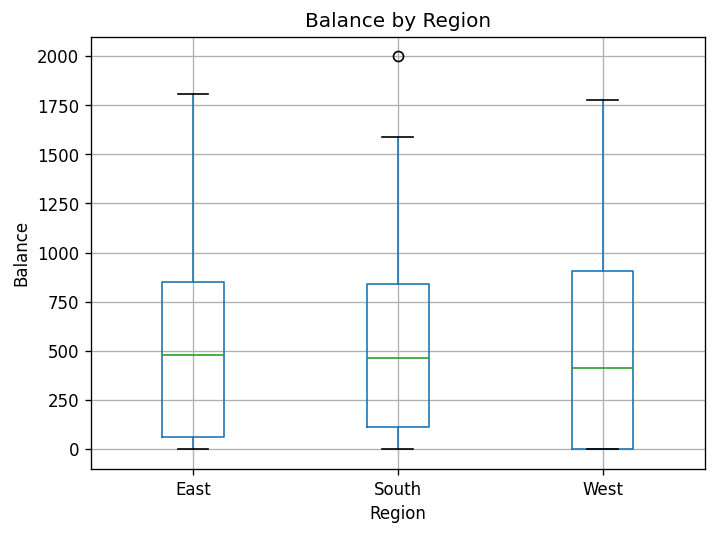

In [61]:

# Visualization: boxplots for both examples (matplotlib, no custom colors/styles)
plt.figure()
df.boxplot(column="Balance", by=binary_var)
plt.title(f"Balance by {binary_var}")
plt.suptitle("")
plt.xlabel(binary_var)
plt.ylabel("Balance")
plt.show()

plt.figure()
df.boxplot(column="Balance", by=multi_var, rot=0)
plt.title(f"Balance by {multi_var}")
plt.suptitle("")
plt.xlabel(multi_var)
plt.ylabel("Balance")
plt.show()



### Notes
- Coefficients on factor levels are **relative to the chosen baseline**.
- Changing the baseline **does not** alter overall fit (e.g., RSS), but it **does** change which coefficient gets the baseline and, therefore, individual t-tests/p-values for level-differences.


# Interactions:
We will use the attached datasets **Advertising.csv** and **Credit.csv** to:
- Fit additive vs. interaction models
- Produce coefficient tables with t-stats and p-values
- Quantify the incremental R² from adding an interaction
- Provide interpretable marginal effects (per $1,000)
- Visualize interaction patterns and predicted lines


## Setup

In [62]:
import os
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

# Ensure output directories exist (e.g., for saving figures used in Quarto)
FIG_DIR = Path("figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

## Load Data

In [63]:
# Attempt to read from the provided mount path; fallback to local if needed.
def load_csv(candidate_paths):
    for p in candidate_paths:
        if Path(p).exists():
            return pd.read_csv(p)
    raise FileNotFoundError(f"None of these files were found: {candidate_paths}")

ad_paths = ["/mnt/data/Advertising.csv", "Advertising.csv"]
cr_paths = ["/mnt/data/Credit.csv", "Credit.csv"]

ad = load_csv(ad_paths)
cr = load_csv(cr_paths)

# Standardize variable names (lower snake for formulas) without losing original columns
ad_renamed = ad.rename(columns={c: c.strip().lower() for c in ad.columns})
cr_renamed = cr.rename(columns={c: c.strip().lower() for c in cr.columns})

# Peek first rows
display(ad_renamed.head())
display(cr_renamed.head())

,unnamed: 0,tv,radio,newspaper,sales
0,1,230.1000,37.8000,69.2000,22.1000
1,2,44.5000,39.3000,45.1000,10.4000
2,3,17.2000,45.9000,69.3000,9.3000
3,4,151.5000,41.3000,58.5000,18.5000
4,5,180.8000,10.8000,58.4000,12.9000


,income,limit,rating,cards,age,education,own,student,married,region,balance
0,14.8910,3606,283,2,34,11,No,No,Yes,South,333
1,106.0250,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.5930,7075,514,4,71,11,No,No,No,West,580
3,148.9240,9504,681,3,36,11,Yes,No,No,West,964
4,55.8820,4897,357,2,68,16,No,No,Yes,South,331


## Advertising: Additive vs. Interaction Models
We begin by comparing:
- **Additive model:** `sales ~ TV + radio`
- **Interaction model:** `sales ~ TV + radio + TV:radio`

In [64]:
# Fit additive and interaction models
m_add = smf.ols("sales ~ tv + radio", data=ad_renamed).fit()
m_int = smf.ols("sales ~ tv + radio + tv:radio", data=ad_renamed).fit()

print("R² (Additive):   ", round(m_add.rsquared, 4))
print("R² (Interaction):", round(m_int.rsquared, 4))

R² (Additive):    0.8972
R² (Interaction): 0.9678


### Coefficient Table (Interaction Model)

In [65]:
def format_p(p):
    return "< 0.0001" if p < 1e-4 else f"{p:.4f}"

def coef_table(fit, order=None, rename=None, dec=4):
    summ = {
        "Term": fit.params.index,
        "Coefficient": fit.params.values,
        "Std. Error": fit.bse.values,
        "t-statistic": fit.tvalues.values,
        "p-value": [format_p(p) for p in fit.pvalues.values],
    }
    df = pd.DataFrame(summ)

    if rename:
        df["Term"] = df["Term"].replace(rename)

    if order:
        # Make 'Term' an ordered categorical, sort by it, then convert back to string for display
        df["Term"] = pd.Categorical(df["Term"], categories=order, ordered=True)
        df = df.sort_values("Term").reset_index(drop=True)
        df["Term"] = df["Term"].astype(str)

    # Round numeric columns (leave p-value as pre-formatted strings)
    for col in ["Coefficient", "Std. Error", "t-statistic"]:
        df[col] = df[col].astype(float).round(dec)

    return df

rename_map = {"Intercept": "Intercept", "tv": "TV", "radio": "radio", "tv:radio": "TV × radio"}
order_terms = ["Intercept", "TV", "radio", "TV × radio"]

tbl_int = coef_table(m_int, order=order_terms, rename=rename_map, dec=4)
display(tbl_int)


,Term,Coefficient,Std. Error,t-statistic,p-value
0,Intercept,6.7502,0.2479,27.2328,< 0.0001
1,TV,0.0191,0.0015,12.6990,< 0.0001
2,radio,0.0289,0.0089,3.2408,0.0014
3,TV × radio,0.0011,0.0001,20.7266,< 0.0001


### R² Improvement from Interaction
We quantify the fraction of **remaining** variance (after the additive model) explained by the interaction:

$$
\frac{R^2_{\text{int}} - R^2_{\text{add}}}{1 - R^2_{\text{add}}}.
$$

In [66]:
R2_add = m_add.rsquared
R2_int = m_int.rsquared
remaining_gain = (R2_int - R2_add) / (1 - R2_add)

summary_r2 = pd.DataFrame(
    {
        "Model": ["Additive (TV + radio)", "Interaction (TV + radio + TV×radio)", "Share of remaining variance explained by interaction"],
        "Value": [f"{R2_add*100:.1f}%", f"{R2_int*100:.1f}%", f"{remaining_gain*100:.1f}%"],
    }
)
display(summary_r2)

,Model,Value
0,Additive (TV + radio),89.7%
1,Interaction (TV + radio + TV×radio),96.8%
2,Share of remaining variance explained by inter...,68.7%


### Interpreting Coefficients (Per \$1,000 Increase)
For the interaction model:

- Effect of a \$1,000 increase in **TV** depends on `radio`:  
  
  $$
  1000\times(\hat{\beta}_{\text{TV}} + \hat{\beta}_{\text{TV×radio}}\cdot \text{radio})
  $$

- Effect of a \$1,000 increase in **radio** depends on `tv`:  
  
  $$
  1000\times(\hat{\beta}_{\text{radio}} + \hat{\beta}_{\text{TV×radio}}\cdot \text{tv})
  $$

In [67]:
b_tv = m_int.params["tv"]
b_radio = m_int.params["radio"]
b_int_tr = m_int.params["tv:radio"]

# Provide symbolic expressions and an example at mean radio/TV
radio_mean = ad_renamed["radio"].mean()
tv_mean = ad_renamed["tv"].mean()

effects = pd.DataFrame(
    {
        "Expression": [
            "Effect of +$1,000 in TV at a given radio",
            "Effect of +$1,000 in radio at a given TV",
        ],
        "General form": [
            f"1000 * (β_TV + β_TV×radio * radio)",
            f"1000 * (β_radio + β_TV×radio * tv)",
        ],
        "With estimates": [
            f"1000 * ({b_tv:.4f} + {b_int_tr:.4f} * radio)",
            f"1000 * ({b_radio:.4f} + {b_int_tr:.4f} * tv)",
        ],
        "Example (at mean levels)": [
            f"{1000*(b_tv + b_int_tr*radio_mean):.2f} in sales (radio = {radio_mean:.2f})",
            f"{1000*(b_radio + b_int_tr*tv_mean):.2f} in sales (tv = {tv_mean:.2f})",
        ],
    }
)
display(effects)

,Expression,General form,With estimates,Example (at mean levels)
0,"Effect of +$1,000 in TV at a given radio",1000 * (β_TV + β_TV×radio * radio),1000 * (0.0191 + 0.0011 * radio),44.38 in sales (radio = 23.26)
1,"Effect of +$1,000 in radio at a given TV",1000 * (β_radio + β_TV×radio * tv),1000 * (0.0289 + 0.0011 * tv),188.62 in sales (tv = 147.04)


### Budget Allocation Example (Synergy)
Using the interaction model, compare predicted sales under a fixed \$100,000 budget:
- All TV, no radio
- All radio, no TV
- Split evenly (TV = 50, radio = 50) — units in the dataset are \$1,000

In [68]:
def predict_sales(tv, radio):
    X = pd.DataFrame({"tv": [tv], "radio": [radio]})
    return m_int.predict(X).iloc[0]

budget = 100  # $100,000
scenarios = pd.DataFrame(
    {
        "Scenario": ["All TV", "All radio", "Even split"],
        "TV (k$)": [budget, 0, budget/2],
        "radio (k$)": [0, budget, budget/2],
    }
)
scenarios["Predicted sales (interaction model)"] = scenarios.apply(
    lambda r: predict_sales(r["TV (k$)"], r["radio (k$)"]), axis=1
)
display(scenarios)

,Scenario,TV (k$),radio (k$),Predicted sales (interaction model)
0,All TV,100.0000,0.0000,8.6603
1,All radio,0.0000,100.0000,9.6363
2,Even split,50.0000,50.0000,11.8645


## Modeling Interactions (Specification)
We estimate:

$$
\text{sales} = \beta_0 + \beta_1 \cdot \text{TV} + \beta_2 \cdot \text{radio} + \beta_3 \cdot (\text{TV}\times\text{radio}) + \epsilon.
$$

The table above (`tbl_int`) provides the estimates, standard errors, t-statistics, and p-values.


## Hierarchy Principle (Code Illustration)
If you include an interaction, include the corresponding main effects as well.  
Below shows the (not recommended) model with only `tv:radio` interaction.

In [69]:
m_only_interaction = smf.ols("sales ~ tv:radio", data=ad_renamed).fit()
pd.DataFrame(
    {
        "Model": ["Only interaction"],
        "R²": [f"{m_only_interaction.rsquared*100:.1f}%"],
        "Note": ["Omitting main effects makes interpretation fragile"],
    }
)

,Model,R²,Note
0,Only interaction,92.9%,Omitting main effects makes interpretation fra...


---
# Interactions Between Qualitative and Quantitative Variables (Credit)
Predict `balance` using quantitative `income` and qualitative `student`.


In [70]:
# Prepare student as categorical and numeric indicator (if needed)
# In ISLR's Credit data, 'student' is 'Yes'/'No'. We'll use the categorical directly.
if "student" not in cr_renamed.columns:
    # fall back to original column casing if needed
    cr_renamed["student"] = cr.get("Student", cr_renamed.get("student"))

cr_renamed["student"] = cr_renamed["student"].astype("category")

# Fit without and with interaction:
m_cr_noi = smf.ols("balance ~ income + C(student)", data=cr_renamed).fit()
m_cr_int = smf.ols("balance ~ income * C(student)", data=cr_renamed).fit()

print("R² (No interaction):", round(m_cr_noi.rsquared, 4))
print("R² (With interaction):", round(m_cr_int.rsquared, 4))

R² (No interaction): 0.2775
R² (With interaction): 0.2799


### Coefficient Table (Interaction Model, Credit)

In [71]:
# Build a readable table (terms may appear with coded names from patsy; we map them)
cr_rename = {
    "Intercept": "Intercept",
    "income": "income",
    "C(student)[T.Yes]": "student=Yes",
    "income:C(student)[T.Yes]": "income × student=Yes",
}
cr_order = ["Intercept", "income", "student=Yes", "income × student=Yes"]

tbl_cr_int = coef_table(m_cr_int, order=cr_order, rename=cr_rename, dec=4)
display(tbl_cr_int)

,Term,Coefficient,Std. Error,t-statistic,p-value
0,Intercept,200.6232,33.6984,5.9535,< 0.0001
1,income,6.2182,0.5921,10.5020,< 0.0001
2,student=Yes,476.6758,104.3512,4.5680,< 0.0001
3,income × student=Yes,-1.9992,1.7313,-1.1547,0.2489


### Visualizing Interactions (Credit)
Left: no interaction (parallel lines). Right: with interaction (different slopes).

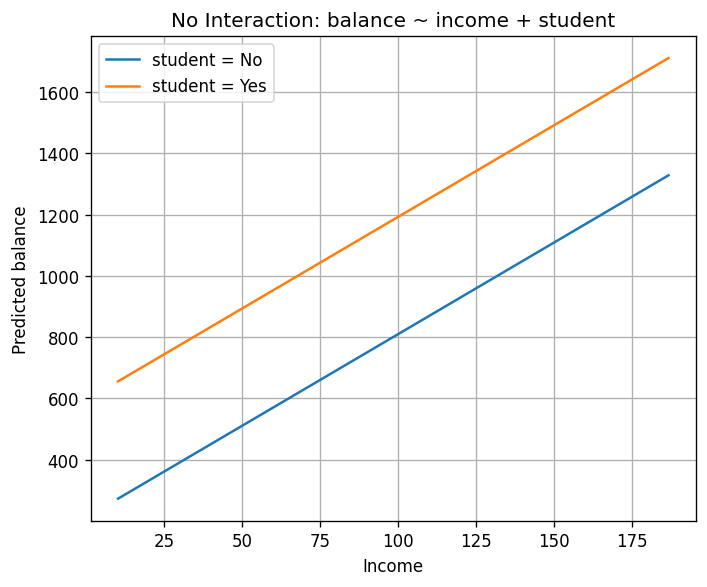

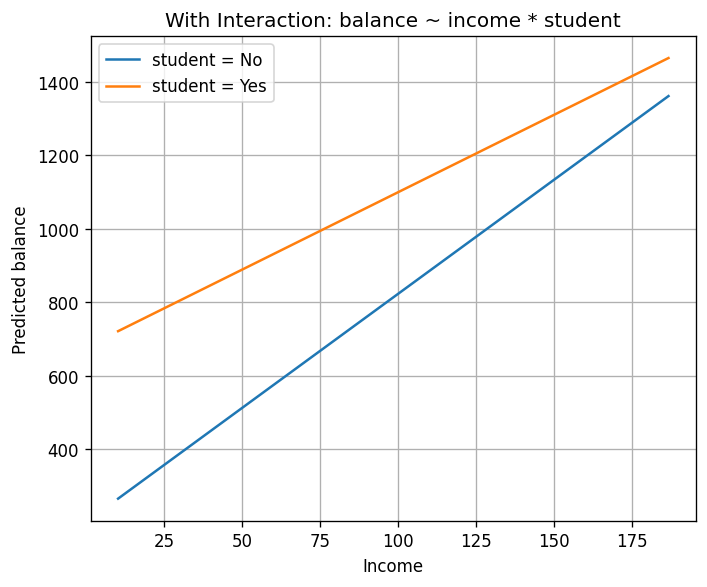

Saved figures to: figs/3_7-1_left_py.png and figs/3_7-1_right_py.png


In [72]:
# Create a grid over income and generate predictions for student=No/Yes
income_min, income_max = cr_renamed["income"].min(), cr_renamed["income"].max()
grid_income = np.linspace(income_min, income_max, 100)

def predict_line(fit, student_label):
    df = pd.DataFrame({"income": grid_income, "student": pd.Categorical([student_label]*len(grid_income), categories=cr_renamed["student"].cat.categories)})
    df["pred"] = fit.predict(df)
    return df

noi_no  = predict_line(m_cr_noi, "No")
noi_yes = predict_line(m_cr_noi, "Yes")
int_no  = predict_line(m_cr_int, "No")
int_yes = predict_line(m_cr_int, "Yes")

# Plot: No interaction
fig1, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(noi_no["income"],  noi_no["pred"],  label="student = No")
ax1.plot(noi_yes["income"], noi_yes["pred"], label="student = Yes")
ax1.set_xlabel("Income")
ax1.set_ylabel("Predicted balance")
ax1.set_title("No Interaction: balance ~ income + student")
ax1.legend()
plt.tight_layout()
p1 = FIG_DIR / "3_7-1_left_py.png"
plt.savefig(p1, bbox_inches="tight")
plt.show()

# Plot: With interaction
fig2, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot(int_no["income"],  int_no["pred"],  label="student = No")
ax2.plot(int_yes["income"], int_yes["pred"], label="student = Yes")
ax2.set_xlabel("Income")
ax2.set_ylabel("Predicted balance")
ax2.set_title("With Interaction: balance ~ income * student")
ax2.legend()
plt.tight_layout()
p2 = FIG_DIR / "3_7-1_right_py.png"
plt.savefig(p2, bbox_inches="tight")
plt.show()

print("Saved figures to:", p1, "and", p2)

### Credit Model R² Summary

In [73]:
pd.DataFrame(
    {
        "Model": ["No interaction (income + student)", "With interaction (income * student)"],
        "R²": [f"{m_cr_noi.rsquared*100:.1f}%", f"{m_cr_int.rsquared*100:.1f}%"],
    }
)

,Model,R²
0,No interaction (income + student),27.7%
1,With interaction (income * student),28.0%



# Non-linear effects of predictors — Polynomial regression on Auto data

This notebook:
- Loads **Auto.csv** (expects the file in the same folder as the notebook; falls back to `/mnt/data/Auto.csv` if needed).
- Cleans `horsepower`.
- Fits a quadratic model: `mpg ~ horsepower + horsepower^2`.
- Plots the scatter with the fitted curve and 95% CI.
- Produces a tidy coefficient table.


In [74]:
# setup
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Display options
pd.set_option("display.float_format", lambda x: f"{x:.4f}")


In [75]:

# Load Auto.csv (prefer local path; fallback to /mnt/data for hosted environments)
possible_paths = ["./Auto.csv", "/mnt/data/Auto.csv"]
csv_path = None
for p in possible_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Auto.csv not found. Place Auto.csv in the same directory as this notebook.")

df = pd.read_csv(csv_path, na_values=["?"]).copy()
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")
df = df.dropna(subset=["mpg", "horsepower"]).copy()

df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0000,8,307.0000,130.0000,3504,12.0000,70,1,chevrolet chevelle malibu
1,15.0000,8,350.0000,165.0000,3693,11.5000,70,1,buick skylark 320
2,18.0000,8,318.0000,150.0000,3436,11.0000,70,1,plymouth satellite
3,16.0000,8,304.0000,150.0000,3433,12.0000,70,1,amc rebel sst
4,17.0000,8,302.0000,140.0000,3449,10.5000,70,1,ford torino


In [76]:

# Quadratic OLS fit: mpg ~ horsepower + horsepower^2
model = smf.ols("mpg ~ horsepower + I(horsepower**2)", data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           5.40e-99
Time:                        16:16:11   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             56.9001      1

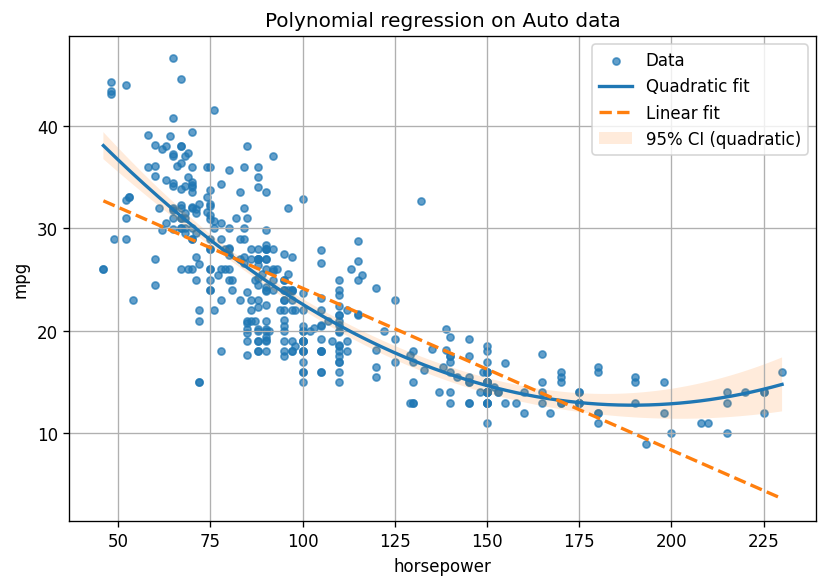

In [77]:
import os, numpy as np, pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Grid of horsepower values for smooth curves
xs = np.linspace(df["horsepower"].min(), df["horsepower"].max(), 200)

# Quadratic model and its 95% CI for the mean prediction
quad_model = smf.ols("mpg ~ horsepower + I(horsepower**2)", data=df).fit()
qpred = quad_model.get_prediction(pd.DataFrame({"horsepower": xs}))
sf = qpred.summary_frame(alpha=0.05)  # 95% CI
mean  = sf["mean"].to_numpy()
lower = sf["mean_ci_lower"].to_numpy()
upper = sf["mean_ci_upper"].to_numpy()

# Linear model for comparison (mean prediction on the same grid)
lin_model = smf.ols("mpg ~ horsepower", data=df).fit()
lin_mean = lin_model.get_prediction(pd.DataFrame({"horsepower": xs})).predicted_mean

# Plot: scatter + quadratic fit + linear fit + 95% CI (quadratic)
os.makedirs("figs", exist_ok=True)
plt.figure(figsize=(7,5))
plt.scatter(df["horsepower"], df["mpg"], s=18, alpha=0.7, label="Data")
plt.plot(xs, mean, linewidth=2, label="Quadratic fit")
plt.plot(xs, lin_mean, linewidth=2, linestyle="--", label="Linear fit")
plt.fill_between(xs, lower, upper, alpha=0.15, label="95% CI (quadratic)")
plt.xlabel("horsepower")
plt.ylabel("mpg")
plt.title("Polynomial regression on Auto data")
plt.legend()
plt.tight_layout()
# plt.savefig("figs/3_8-1.png", dpi=300, bbox_inches="tight")
plt.show()


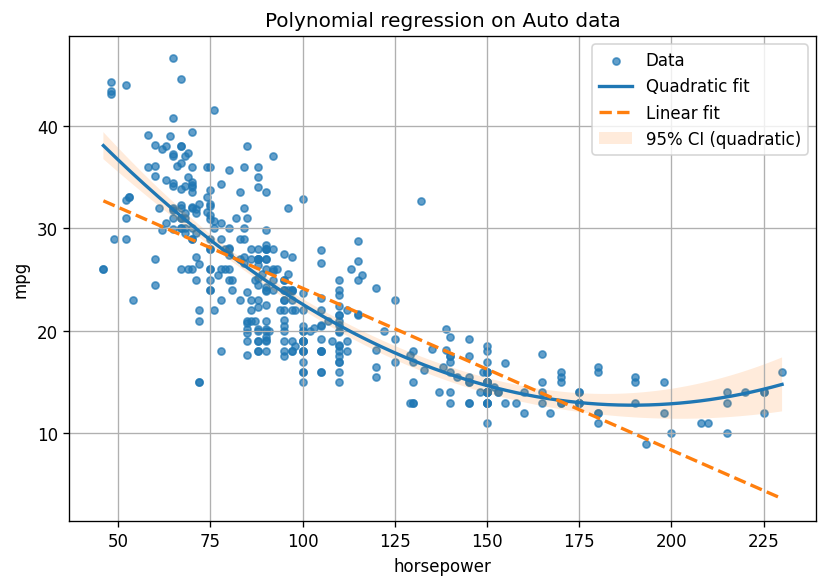

In [78]:
# Fit a linear model for comparison
lin_model = smf.ols("mpg ~ horsepower", data=df).fit()
lin_mean = lin_model.get_prediction(pd.DataFrame({"horsepower": xs})).predicted_mean

# Plot: scatter + quadratic fit + linear fit + 95% CI (quadratic)
os.makedirs("figs", exist_ok=True)
plt.figure(figsize=(7,5))
plt.scatter(df["horsepower"], df["mpg"], s=18, alpha=0.7, label="Data")
plt.plot(xs, mean, linewidth=2, label="Quadratic fit")
plt.plot(xs, lin_mean, linewidth=2, linestyle="--", label="Linear fit")
plt.fill_between(xs, lower, upper, alpha=0.15, label="95% CI (quadratic)")
plt.xlabel("horsepower")
plt.ylabel("mpg")
plt.title("Polynomial regression on Auto data")
plt.legend()
plt.tight_layout()
#plt.savefig("figs/3_8-1.png", dpi=300, bbox_inches="tight")
plt.show()

#print("Figure saved to figs/3_8-1.png")


In [79]:
# Root cause: set_index(pd.Categorical(...)) passes a Categorical *array* to set_index,
# which raises "unhashable type: 'Categorical'" in pandas 2.x.
# Fix by reindexing on a normal Index (preferred), or by sorting an ordered categorical.

def format_p(p):
    return "< 0.0001" if p < 1e-4 else f"{p:.4f}"

out = pd.DataFrame({
    "Term": model.params.index,
    "Coefficient": model.params.values,
    "Std. Error": model.bse.values,
    "t-statistic": model.tvalues.values,
    "p-value": [format_p(p) for p in model.pvalues.values]
})

rename_map = {
    "Intercept": "Intercept",
    "horsepower": "horsepower",
    "I(horsepower ** 2)": r"$\mathrm{horsepower}^2$"
}
out["Term"] = out["Term"].replace(rename_map)

for col in ["Coefficient", "Std. Error", "t-statistic"]:
    out[col] = out[col].astype(float).round(4)

order = ["Intercept", "horsepower", r"$\mathrm{horsepower}^2$"]

# --- Option A (recommended): reindex on a normal Index ---
out = (
    out
    .set_index("Term")   # make Term the (string) index
    .reindex(order)      # put rows in desired order
    .reset_index()       # back to a column
)

# --- Option B: ordered categorical + sort (no set_index needed) ---
# out["Term"] = pd.Categorical(out["Term"], categories=order, ordered=True)
# out = out.sort_values("Term").reset_index(drop=True)
# out["Term"] = out["Term"].astype(str)  # optional: back to plain strings

out
# print(out.to_markdown(index=False))  # for Quarto


,Term,Coefficient,Std. Error,t-statistic,p-value
0,Intercept,56.9001,1.8004,31.6037,< 0.0001
1,horsepower,-0.4662,0.0311,-14.9782,< 0.0001
2,$\mathrm{horsepower}^2$,0.0012,0.0001,10.0801,< 0.0001
